In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

/Users/marvynbailly/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


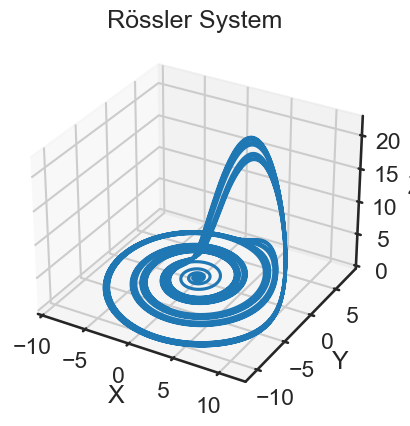

In [2]:
npr.seed(12345)
np.random.seed(999)

def rossler_system_deriv(t, xyz, a, b, c):
    x, y, z = xyz
    dx_dt = -y - z
    dy_dt = x + a * y
    dz_dt = b + z * (x - c)
    return [dx_dt, dy_dt, dz_dt]

def generate_rossler_data(x0, y0, z0, a, b, c, t_start, t_end, dt):
    t = np.arange(t_start, t_end, dt)
    xyz0 = [x0, y0, z0]
    sol = solve_ivp(lambda t, xyz: rossler_system_deriv(t, xyz, a, b, c), (t_start, t_end), xyz0, t_eval=t)

    return sol.t, sol.y.T

# Rössler system parameters
a = 0.2
b = 0.2
c = 5.7

# Initial conditions
x0 = 0.1
y0 = 0.0
z0 = 0.0

# Time parameters
t_start = 0.0
t_end = 200.0
dt = 0.01

# Generate Rössler data
t, xyz = generate_rossler_data(x0, y0, z0, a, b, c, t_start, t_end, dt)

# Plot the trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rössler System')
plt.show()

In [4]:
noise0=np.random.normal(loc=0.0, scale=1.0, size=xyz[:,0].shape)
noise0=noise0.reshape(-1,1)
rossler_data_noise=np.concatenate([xyz,noise0],1)
T = 2000
K = 3
D_obs = 4
D_latent = 3

#data = np.random.randn(100,10)
data = rossler_data_noise
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)
q_elbos_lem, q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, data)))
zhat_lem = rslds.most_likely_states(xhat_lem, data)

# store rslds
rslds_lem = copy.deepcopy(rslds)
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)

q_elbos_bbvi, q_bbvi = rslds.fit(data, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=100)

ELBO: -238457.8: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


In [5]:
xhat_bbvi = q_bbvi.mean[0]
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, data)

In [7]:
# Helper functions for plotting results
def plot_3D_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca(projection='3d')
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                x[start:stop + 1, 2],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

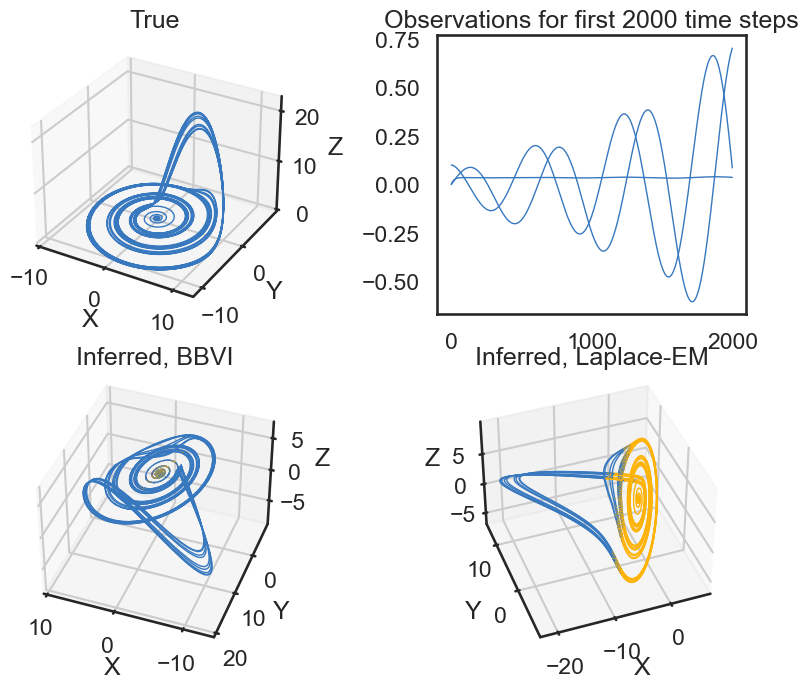

In [15]:
x=data
z=(x[:,0]>x[:,0].mean()).astype(int)
z=(0*z).astype(int)
fig = plt.figure(figsize=(8, 12))
ax1 = fig.add_subplot(221, projection='3d')
plot_3D_trajectory(z, x[:,0:3],ax=ax1)
plt.title("True")
plt.xlabel('X')
plt.ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(222)
ax2.set_position([0.5, 0.5, 0.2, 0.8]) 
plot_observations(z[:2000], data[:2000,:3],ax=ax2)
plt.title("Observations for first 2000 time steps")

ax3 = fig.add_subplot(223, projection='3d')
plot_3D_trajectory(zhat_bbvi, xhat_bbvi,ax=ax3)
ax3.view_init(azim=110, elev=40)  #azim:  camera around the z-axis
plt.title("Inferred, BBVI")
plt.xlabel('X')
plt.ylabel('Y')
ax3.set_zlabel('Z')

ax4 = fig.add_subplot(224, projection='3d')
plot_3D_trajectory(zhat_lem, xhat_lem,ax=ax4)
ax4.view_init(azim=-110, elev=40)  #azim:  camera around the z-axis
plt.title("Inferred, Laplace-EM")
plt.xlabel('X')
plt.ylabel('Y')
ax4.set_zlabel('Z')

plt.tight_layout()